In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

In [18]:
train = pd.read_csv('logistic_news_train.txt')
test = pd.read_csv('logistic_news_test.txt')
#Now, we remove spaces present within column names for easier analysis
train.columns = train.columns.str.replace(' ', '')
test.columns = test.columns.str.replace(' ', '')

In [23]:
def logit(train, weights, biases):
    logit_scores = (weights.dot(train.T).T) + biases[:,0]
    return logit_scores

In [27]:
def softmax(logits: np.ndarray, n_cls: int):


    probs = np.array([np.empty([n_cls]) for i in range(logits.shape[0])])

    for i in range(logits.shape[0]):
        exp = np.exp(logits[i])
        denom = np.sum(exp)

        # logit scores to probability values
        probs[i] = exp / denom

    return probs


def linearPredict(X: np.ndarray, W: np.ndarray, biases: np.ndarray, n_cls: int):

    logits = W.dot(X.T).T

    return logits


# def cross_entropy(probs: np.ndarray, y: np.ndarray, W:np.ndarray) -> float:

#     n = probs.shape[0]

#     L2 = np.sum(W ** 2 / (2*n))

#     axis0 = np.arange(n)

#     CELoss = -np.log(probs[axis0, y.squeeze(-1)]).sum() + L2

#     return CELoss / n

def cross_entropy(probabilities, gt_classes, weights):
    prob_length = len(probabilities)
    lamb = 1/len(gt_classes)
    L2 = (weights.T.dot(weights))*lamb
    #L2norm = np.linalg.norm(weights)
    cross_entropy.log_likelihood = np.log(probabilities[np.arange(prob_length), gt_classes.squeeze(-1)])
    loss = cross_entropy.log_likelihood.sum() #+ ((L2norm)**2)/len(gt_classes) + L2 
    averaged_loss = loss/prob_length
    return averaged_loss

In [30]:
def newton_raphson(training, gt_classes, weights,
       biases, step_size, output_nums,
       iterations):

    n = len(gt_classes)

    lamb = 1/n
    L2 = lamb * (weights.T.dot(weights))
    reg = lamb*np.eye(2001)

    axis0 = np.arange(len(training))

    cost_history = np.zeros(iterations)

    for x in range(iterations):

        logitScores = logit(training, weights, biases)
        probs = softmax(logitScores, output_nums)
        # error
        cost_history[x] = cross_entropy(probs, gt_classes, weights)

        pi = np.sum(probs*(1-probs), axis=1)
        diagonal = np.expand_dims(pi, axis=0) * np.identity(len(pi))
        
        # probability error
        probs[axis0, gt_classes.squeeze(-1)] -= 1

        # n_feats x n_feats
        hessian = training.T.dot(diagonal).dot(training) #+ L2
        hessian = hessian + reg

        # first derivative w.r.t weights
        firstD = probs.T.dot(training).T

        # gradient of weights and biases
        gradsW = np.linalg.inv(hessian).dot(firstD).T + (2*weights/n)

        gradsBiases = np.sum(probs, axis=0).reshape(-1, 1)

        # update weights
        weights = weights - (step_size * gradsW) 

        # update biases
        biases = biases - (step_size * gradsBiases)

    return weights, biases, cost_history


step_size = .01
iterations = 100
output_nums = len(np.unique(train['Var2'].values))
features = train.shape[1] - 1

weights = np.random.rand(output_nums, features)
biases = np.random.rand(output_nums, 1)




X = train.loc[:, :'X_train_2001'].to_numpy()
X_test = test.loc[:, :'X_test_2001'].to_numpy()
y = train.loc[:, 'Var2'].to_numpy().reshape(-1, 1)
y_test = test.loc[:, 'Var2'].to_numpy().reshape(-1, 1)


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

weights, biases, log_likelihood = newton_raphson(X, y, weights, biases, step_size, output_nums, iterations)

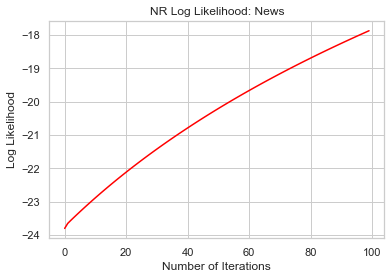

In [32]:
x = np.arange(iterations)
sns.set_style('whitegrid')
ax = sns.lineplot(x=x, y=log_likelihood, color = 'red')

ax.set_title("NR Log Likelihood: News")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Log Likelihood")
plt.show()


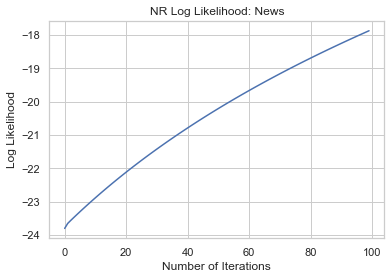

In [33]:
x = np.arange(iterations)
sns.set_style('whitegrid')
ax = sns.lineplot(x=x, y=log_likelihood)

ax.set_title("NR Log Likelihood: News")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Log Likelihood")
plt.show()

In [34]:
def predict(x_test, W, y, biases, n_cls):
    logit_scores = logit(x_test, W, biases)
    probs = softmax(logit_scores, n_cls)
    y_hat = np.argmax(probs, axis = 1).reshape(-1,1)
    accuracy = (y_hat == y).sum() / len(y) * 100
    return accuracy

# feature and label vectors
X_test = test.loc[:, :'X_test_2001'].to_numpy()
y_test = test.loc[:, 'Var2'].to_numpy().reshape(-1, 1)


#X_test = X_test / 255
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
output_nums=20
acc = predict(X_test, weights, y_test, biases, output_nums)

print(f"Digits accuracy: {acc:.2f}%")


Digits accuracy: 5.05%
